In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Reading + Cleaning the Data

In [2]:
fname = "SPX_database_2010.xlsx"
df_SPX = pd.read_excel(fname, sheet_name="SPX_memb")[["Ticker", "Name"]]
df_mktcap_inicial = pd.read_excel(fname, sheet_name="mkt_cap")
df_price_inicial  = pd.read_excel(fname, sheet_name="prices")
df_total_ret_inicial = pd.read_excel(fname, sheet_name="total_ret")

In [3]:
for df in (df_price_inicial, df_mktcap_inicial, df_total_ret_inicial):
    df["Dates"] = pd.to_datetime(df["Dates"], errors="coerce")
    df.sort_values("Dates", inplace=True)
    df.reset_index(drop=True, inplace=True)

df_price = df_price_inicial[df_price_inicial["Dates"].dt.year >= 2014].reset_index(drop=True)
df_mktcap = df_mktcap_inicial[df_mktcap_inicial["Dates"].dt.year >= 2014].reset_index(drop=True)
df_total_ret = df_total_ret_inicial[df_total_ret_inicial["Dates"].dt.year >= 2014].reset_index(drop=True)

In [ ]:
def _complete_cols(df):
    cols = [c for c in df.columns if c != "Dates"]
    complete = [c for c in cols if not df[c].isna().any()]
    return df[["Dates"] + complete].copy()

df_price_v1 = _complete_cols(df_price)
df_mktcap_v1 = _complete_cols(df_mktcap)
‹›ﬁﬂdf_total_ret_v1 = _complete_cols(df_total_ret)

### Choosing 30 stocks and aligning data

In [5]:
def _choose_30(spx_df, px_df, tri_df, mkt_df, random_state=42):
    spx = set(spx_df["Ticker"].astype(str).str.strip())
    tick_px = [c for c in px_df.columns  if c != "Dates" and c in spx]
    tick_tri = [c for c in tri_df.columns if c != "Dates"]
    tick_mkt = [c for c in mkt_df.columns if c != "Dates"]
    
    eligible = sorted(set(tick_px) & set(tick_tri) & set(tick_mkt))
    rng = np.random.default_rng(random_state)
    
    return sorted(rng.choice(eligible, size=30, replace=False))


def _align_on_dates(px, tri, mkt, tickers):
    p = px[["Dates"] + tickers].copy()
    t = tri[["Dates"] + tickers].copy()
    m = mkt[["Dates"] + tickers].copy()

    pt = p.merge(t, on="Dates", suffixes=("_px", "_tri"))
    ptm = pt.merge(m, on="Dates")
    prices = pd.concat([ptm[["Dates"]], ptm[[f"{x}_px"  for x in tickers]].set_axis(tickers, axis=1)], axis=1)
    tris = pd.concat([ptm[["Dates"]], ptm[[f"{x}_tri" for x in tickers]].set_axis(tickers, axis=1)], axis=1)
    mktcap = pd.concat([ptm[["Dates"]], ptm[[x for x in tickers]]], axis=1)
    
    return prices, tris, mktcap


tickers30 = _choose_30(df_SPX, df_price_v1, df_total_ret_v1, df_mktcap_v1, random_state=42)
prices_30, tri_30, mktcap_30 = _align_on_dates(df_price_v1, df_total_ret_v1, df_mktcap_v1, tickers30)

### Separating month windows

In [6]:
dates_series = pd.Series(prices_30["Dates"]).reset_index(drop=True)
groups = dates_series.groupby([dates_series.dt.year, dates_series.dt.month], sort=True).groups

month_windows = []
for _, locs in groups.items():
    locs = sorted(locs)
    month_windows.append((locs[0], locs[-1]))

# Calculate daily returns and values

In [7]:
tickers = tickers30
n = len(tickers)

capital_ew = 100_000_000.0
capital_vw = 100_000_000.0

ew_vals_parts = []
vw_vals_parts = []
w_ew_rows, w_vw_rows = [], []
s_ew_rows, s_vw_rows = [], []


for start_idx, end_idx in month_windows:
    prev_idx = start_idx - 1

    w_ew = pd.Series(1.0 / n, index=tickers)

    prev_mktcap = (
        mktcap_30.iloc[prev_idx][tickers]      # positional previous row
        .astype(float)
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0.0)
    )
    total_prev = float(prev_mktcap.sum())
    w_vw = (prev_mktcap / total_prev) if total_prev > 0 else pd.Series(1.0 / n, index=tickers)

    prices_0 = (prices_30.loc[start_idx, tickers])
    px_safe = prices_0.replace(0.0, np.nan)

    shares_ew = (w_ew * capital_ew) / px_safe
    shares_vw = (w_vw * capital_vw) / px_safe
    shares_ew = shares_ew
    shares_vw = shares_vw

    tri_win = tri_30.loc[start_idx:end_idx, tickers]
    tri_base = tri_win.iloc[0].replace(0.0, np.nan)
    growth = tri_win.divide(tri_base, axis=1).fillna(1.0)

    start_pos_val_ew = shares_ew * prices_0
    start_pos_val_vw = shares_vw * prices_0

    vals_ew = growth.mul(start_pos_val_ew, axis=1).sum(axis=1)
    vals_vw = growth.mul(start_pos_val_vw, axis=1).sum(axis=1)

    ew_vals_parts.append(vals_ew)
    vw_vals_parts.append(vals_vw)

    rebalance_date = prices_30.loc[start_idx, "Dates"]
    w_ew_rows.append({"rebalance_date": rebalance_date, **{f"w_{t}": w_ew[t] for t in tickers}})
    w_vw_rows.append({"rebalance_date": rebalance_date, **{f"w_{t}": w_vw[t] for t in tickers}})
    s_ew_rows.append({"rebalance_date": rebalance_date, **{f"s_{t}": shares_ew[t] for t in tickers}})
    s_vw_rows.append({"rebalance_date": rebalance_date, **{f"s_{t}": shares_vw[t] for t in tickers}})

    capital_ew = float(vals_ew.iloc[-1])
    capital_vw = float(vals_vw.iloc[-1])



EW_Value = pd.concat(ew_vals_parts)
VW_Value = pd.concat(vw_vals_parts)
EW_Value.index = prices_30.loc[EW_Value.index, "Dates"].values
VW_Value.index = prices_30.loc[VW_Value.index, "Dates"].values

EW_Return = EW_Value.pct_change().rename("EW_Return")
VW_Return = VW_Value.pct_change().rename("VW_Return")

daily_returns = pd.concat([EW_Return, VW_Return], axis=1)
daily_values = pd.concat([EW_Value.rename("EW_Value"), VW_Value.rename("VW_Value")], axis=1)

weights_ew = pd.DataFrame(w_ew_rows)
weights_vw = pd.DataFrame(w_vw_rows)
shares_ew = pd.DataFrame(s_ew_rows)
shares_vw = pd.DataFrame(s_vw_rows)

display(daily_returns, daily_values, weights_ew, weights_vw, shares_ew, shares_vw)

/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_63795/1279008340.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  EW_Return = EW_Value.pct_change().rename("EW_Return")
/var/folders/pm/ps47mfm943x_nqjshcjsk5ch0000gn/T/ipykernel_63795/1279008340.py:65: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  VW_Return = VW_Value.pct_change().rename("VW_Return")


,EW_Return,VW_Return
2014-01-01,NaN,NaN
2014-01-02,-1.154481e-02,-8.774450e-03
2014-01-03,-4.353954e-04,-5.020505e-03
2014-01-06,-2.083520e-03,4.366228e-03
2014-01-07,2.189098e-03,5.288264e-03
...,...,...
2025-07-28,-7.855133e-03,-4.785613e-03
2025-07-29,-1.013293e-03,7.769358e-03
2025-07-30,-1.251760e-02,4.827664e-04
2025-07-31,-1.175627e-03,-1.975873e-02


,EW_Value,VW_Value
2014-01-01,100000000.0,100000000.0
2014-01-02,98845519.15653,99122555.033153
2014-01-03,98802482.276353,98624909.739255
2014-01-06,98596625.283076,99055528.552033
2014-01-07,98812462.97933,99579360.302917
...,...,...
2025-07-28,435519432.421537,394730692.306235
2025-07-29,435078123.497661,397797496.371391
2025-07-30,429631989.146045,397989539.621395
2025-07-31,429126902.068333,390125772.20128


,rebalance_date,w_ARE UN Equity,w_ATO UN Equity,w_AVY UN Equity,w_BK UN Equity,w_CHRW UW Equity,w_CLX UN Equity,w_FCX UN Equity,w_GIS UN Equity,w_GM UN Equity,...,w_ON UW Equity,w_PFE UN Equity,w_PHM UN Equity,w_PRU UN Equity,w_RCL UN Equity,w_SJM UN Equity,w_SNA UN Equity,w_UDR UN Equity,w_VLO UN Equity,w_ZBH UN Equity
0,2014-01-01,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
1,2014-02-03,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
2,2014-03-03,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
3,2014-04-01,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
4,2014-05-01,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2025-04-01,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
136,2025-05-01,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
137,2025-06-02,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
138,2025-07-01,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


,rebalance_date,w_ARE UN Equity,w_ATO UN Equity,w_AVY UN Equity,w_BK UN Equity,w_CHRW UW Equity,w_CLX UN Equity,w_FCX UN Equity,w_GIS UN Equity,w_GM UN Equity,...,w_ON UW Equity,w_PFE UN Equity,w_PHM UN Equity,w_PRU UN Equity,w_RCL UN Equity,w_SJM UN Equity,w_SNA UN Equity,w_UDR UN Equity,w_VLO UN Equity,w_ZBH UN Equity
0,2014-01-01,0.003356,0.006318,0.003301,0.018230,0.003451,0.003874,0.014677,0.006777,0.012768,...,0.006062,0.034095,0.005881,0.009102,0.021792,0.002948,0.004232,0.003271,0.010562,0.004577
1,2014-02-03,0.004852,0.004230,0.004611,0.035361,0.008598,0.011033,0.032591,0.029050,0.048542,...,0.003599,0.190845,0.007540,0.037847,0.010592,0.009816,0.005641,0.005912,0.026707,0.015563
2,2014-03-03,0.004838,0.004317,0.004472,0.033960,0.007352,0.010602,0.031671,0.029214,0.053808,...,0.003846,0.191630,0.007483,0.036614,0.010948,0.009696,0.006096,0.006068,0.023889,0.014856
3,2014-04-01,0.005014,0.004554,0.004691,0.038639,0.007446,0.011029,0.033126,0.030717,0.052785,...,0.003994,0.198096,0.007056,0.037805,0.011643,0.009726,0.006382,0.006265,0.027286,0.015378
4,2014-05-01,0.005237,0.005061,0.004624,0.038062,0.008592,0.011666,0.035336,0.032257,0.054747,...,0.004105,0.198004,0.006894,0.036982,0.011684,0.009925,0.006689,0.006437,0.030152,0.016154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2025-04-01,0.004732,0.007250,0.004153,0.017793,0.003578,0.005360,0.016077,0.009675,0.013827,...,0.005067,0.042466,0.006123,0.011696,0.016337,0.003723,0.005220,0.004420,0.012272,0.006657
136,2025-05-01,0.003604,0.007310,0.003835,0.016553,0.003024,0.005026,0.014836,0.008908,0.012534,...,0.004804,0.039693,0.005895,0.010437,0.016733,0.003548,0.004705,0.003976,0.010425,0.005845
137,2025-06-02,0.003263,0.006603,0.003734,0.017039,0.003063,0.004369,0.014854,0.007986,0.012820,...,0.004720,0.035895,0.005281,0.009885,0.018756,0.003221,0.004508,0.003689,0.010857,0.004901
138,2025-07-01,0.003243,0.006319,0.003541,0.016826,0.002941,0.003820,0.016071,0.007254,0.012213,...,0.005653,0.035574,0.005456,0.009818,0.021950,0.002704,0.004200,0.003492,0.010868,0.004658


,rebalance_date,s_ARE UN Equity,s_ATO UN Equity,s_AVY UN Equity,s_BK UN Equity,s_CHRW UW Equity,s_CLX UN Equity,s_FCX UN Equity,s_GIS UN Equity,s_GM UN Equity,...,s_ON UW Equity,s_PFE UN Equity,s_PHM UN Equity,s_PRU UN Equity,s_RCL UN Equity,s_SJM UN Equity,s_SNA UN Equity,s_UDR UN Equity,s_VLO UN Equity,s_ZBH UN Equity
0,2014-01-01,52394.425233,73389.109056,66414.292356,95401.640908,57136.327277,35935.029467,88323.617735,66786.883056,81559.416035,...,404530.744337,114801.204494,163639.338897,36145.449288,70293.828202,32168.821978,30435.841247,142755.174875,66137.566138,36870.790738
1,2014-02-03,47358.401106,70464.758657,68843.523883,106483.625910,57013.838158,38112.654897,105901.186514,70239.199250,93373.301471,...,407857.357729,113468.686287,167161.446260,40912.478271,68571.018268,35041.082475,33851.783162,136856.917957,67377.868513,37336.567900
2,2014-03-03,48133.844694,76368.312950,70973.061691,110011.586054,67750.130387,40457.757299,106794.677050,70318.276124,96825.994132,...,374980.668186,115653.075583,168480.021506,42246.888150,68451.176250,35396.963630,31430.472860,134075.305833,72514.358791,38284.391366
3,2014-04-01,48906.063753,74911.503703,68799.569240,99303.755545,67414.608586,39999.385551,106814.884078,67909.346926,102397.961090,...,372100.104109,116100.834808,179131.226889,40973.502492,62657.626227,36198.743914,30858.674716,135976.256142,63346.171570,38030.009862
4,2014-05-01,46899.556466,67285.498619,71171.624777,101631.822362,58800.278957,38595.082429,100977.476417,65497.349453,98865.340091,...,367846.521235,116849.439837,186206.172109,42508.320428,65596.965194,35508.905724,29742.266780,132963.405363,59788.604560,36478.589755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2025-04-01,146763.545637,86339.855330,74501.543689,159693.173986,130181.950027,90443.493914,350839.160367,224003.636718,283061.726297,...,332773.561810,545130.284628,129828.194728,119773.454963,64277.806961,112871.221606,39394.243432,296158.892734,100026.149131,119048.653420
136,2025-05-01,178171.071657,81666.375834,77216.929822,161677.420357,144897.209582,94422.694392,359278.222496,235360.202970,290373.364730,...,330336.365684,546649.397455,128386.692326,128588.617724,59253.159764,114980.399763,41966.315104,307073.241340,113869.429675,128474.956601
137,2025-06-02,194737.637997,87647.048659,76931.204476,152323.439027,141008.526889,104027.474132,337577.574212,250392.381389,284205.066148,...,318611.650320,577738.261066,138941.461862,130827.602361,51745.655727,121015.532184,42825.174902,327305.955195,105640.994580,148762.370811
138,2025-07-01,189885.708154,92057.184513,78112.361390,156035.150584,143877.391928,114493.980900,321102.982983,265925.670247,271854.437832,...,263891.537321,564879.648579,128657.325818,129766.847710,44889.198351,137392.777080,44499.422389,346171.962810,102489.576121,150378.337236


,rebalance_date,s_ARE UN Equity,s_ATO UN Equity,s_AVY UN Equity,s_BK UN Equity,s_CHRW UW Equity,s_CLX UN Equity,s_FCX UN Equity,s_GIS UN Equity,s_GM UN Equity,...,s_ON UW Equity,s_PFE UN Equity,s_PHM UN Equity,s_PRU UN Equity,s_RCL UN Equity,s_SJM UN Equity,s_SNA UN Equity,s_UDR UN Equity,s_VLO UN Equity,s_ZBH UN Equity
0,2014-01-01,5275.593473,13910.755670,6577.533118,52176.161324,5915.871305,4175.854435,38891.071944,13579.047508,31241.107625,...,73566.887329,117424.936281,28869.471048,9869.654748,45955.653891,2845.335671,3864.236183,14009.473216,20957.211255,5063.029033
1,2014-02-03,7268.952156,9428.560416,10041.533383,119112.359737,15507.388738,13302.347246,109181.279873,64545.425020,143380.253424,...,46432.467322,685018.714135,39868.485849,48981.696804,22976.180873,10881.189413,6040.686946,25592.668209,56922.739162,18381.340960
2,2014-03-03,7350.677622,10405.826551,10017.066792,117917.199406,15722.290500,13537.741163,106752.808728,64838.053491,164442.243187,...,45519.577206,699504.973176,39792.455509,48822.155501,23652.174640,10832.168320,6047.091842,25676.466985,54674.621196,17950.705398
3,2014-04-01,7527.335211,10470.148389,9906.294263,117774.293247,15406.833415,13541.271004,108606.580160,64026.727509,165904.992724,...,45611.518557,705942.748563,38795.194582,47545.527306,22391.386753,10806.594095,6045.245294,26147.512204,53054.246914,17951.219439
4,2014-05-01,7424.716807,10295.562903,9948.661839,116947.019934,15272.731895,13612.077853,107871.145577,63871.757435,163632.091296,...,45653.758410,699460.278948,38810.119334,47525.919317,23171.270518,10654.556926,6014.176088,25876.648444,54500.808523,17815.281165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2025-04-01,17322.278739,15614.944700,7717.451998,70879.951316,11619.872349,12092.869558,140698.430182,54059.152505,97634.157539,...,42060.512285,577461.641158,19830.924122,34944.967006,26195.573183,10483.415992,5129.509418,32651.230272,30620.043781,19770.007192
136,2025-05-01,16784.774412,15605.898444,7741.474541,69957.269691,11455.227782,12405.692918,139339.710836,54808.885991,95136.536165,...,41483.459323,567199.548659,19783.542794,35083.823038,25917.868621,10662.663444,5161.304862,31916.578797,31031.084100,19631.263307
137,2025-06-02,16986.734072,15469.965246,7678.932757,69372.252448,11542.773879,12147.597280,134026.360510,53447.985112,97383.959571,...,40192.166389,554292.646914,19611.646369,34565.509672,25941.153806,10418.234128,5160.116777,32273.896050,30656.177092,19488.601933
138,2025-07-01,16526.174106,15609.379605,7422.316840,70453.742772,11353.927308,11737.073227,138482.300944,51767.998788,89095.431159,...,40035.254632,539253.248531,18837.563485,34188.405508,26441.897768,9970.551752,5015.786306,32436.432415,29889.569434,18797.712175


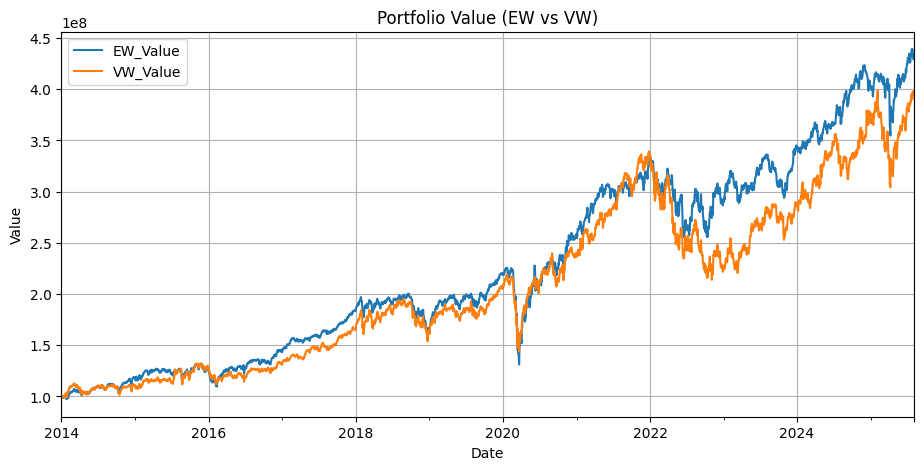

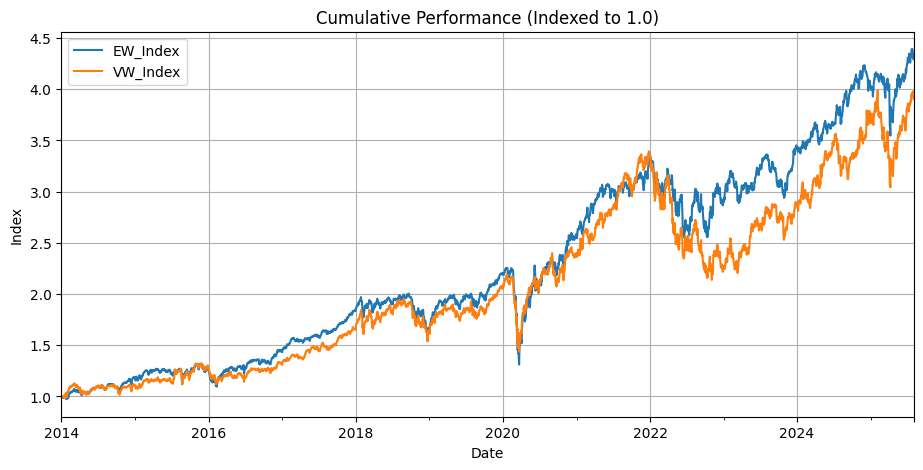

In [8]:
plt.figure(figsize=(11,5))
daily_values.plot(ax=plt.gca())
plt.title("Portfolio Value (EW vs VW)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

plt.figure(figsize=(11,5))
norm_vals = pd.DataFrame({
    "EW_Index": EW_Value / EW_Value.dropna().iloc[0],
    "VW_Index": VW_Value / VW_Value.dropna().iloc[0],
})
norm_vals.plot(ax=plt.gca())
plt.title("Cumulative Performance (Indexed to 1.0)")
plt.xlabel("Date")
plt.ylabel("Index")
plt.legend()
plt.grid(True)

# plt.figure(figsize=(11,5))
# rolling_vol = pd.DataFrame({
#     "EW_RollingVol_21d": daily_returns["EW_Return"].rolling(21).std() * np.sqrt(252),
#     "VW_RollingVol_21d": daily_returns["VW_Return"].rolling(21).std() * np.sqrt(252),
# })
# rolling_vol.plot(ax=plt.gca())
# plt.title("Rolling Volatility (21d, Annualized)")
# plt.xlabel("Date")
# plt.ylabel("Volatility")
# plt.legend()
# plt.grid(True)

plt.show()

# Calculating the yearly turnover

$$
\text{Turnover} = \frac{\min(\text{Total Buys}, \text{Total Sells})}{\text{Average Assets}}
$$

In [9]:
prices = prices_30[["Dates"] + tickers].copy()
prices["Dates"] = pd.to_datetime(prices["Dates"])
prices = prices.set_index("Dates")

def turnover(shares_df):
    rows = []
    for i in range(1, len(shares_df)):
        date_now = pd.to_datetime(shares_df.loc[i, "rebalance_date"])

        prev_shares = shares_df.loc[i-1, [f"s_{t}" for t in tickers]].to_numpy(float)
        curr_shares = shares_df.loc[i, [f"s_{t}" for t in tickers]].to_numpy(float)
        px = prices.loc[date_now, tickers].to_numpy(float)

        prev_val = prev_shares * px
        curr_val = curr_shares * px
        diff = curr_val - prev_val

        buys = diff[diff > 0].sum()
        sells = (-diff[diff < 0]).sum()
        assets = curr_val.sum()

        rows.append({
            "date": date_now, 
            "buys": buys, "sells": sells, 
            "assets": assets
        })

    trades = pd.DataFrame(rows)
    trades["year"] = trades["date"].dt.year
    
    out = (
        trades
        .groupby("year", as_index=False)
        .agg(total_buys=("buys", "sum"),
            total_sells=("sells", "sum"),
            avg_assets=("assets", "mean"))
    )
    out["turnover"] = out[["total_buys", "total_sells"]].min(axis=1) / out["avg_assets"]
    return out[["year", "turnover", "total_buys", "total_sells", "avg_assets"]]

turnover_ew = turnover(shares_ew)
turnover_vw = turnover(shares_vw)

display(turnover_ew, turnover_vw)

,year,turnover,total_buys,total_sells,avg_assets
0,2014,0.203432,2.593726e+07,2.188949e+07,1.076011e+08
1,2015,0.275770,3.413059e+07,3.543808e+07,1.237649e+08
2,2016,0.319488,4.183278e+07,4.134835e+07,1.294206e+08
3,2017,0.233013,3.739787e+07,4.003051e+07,1.604971e+08
4,2018,0.277943,5.802531e+07,5.277527e+07,1.898781e+08
5,2019,0.262233,5.488247e+07,5.082968e+07,1.938344e+08
6,2020,0.436488,9.293517e+07,9.276808e+07,2.125330e+08
7,2021,0.285116,8.350691e+07,1.007205e+08,2.928872e+08
8,2022,0.355393,1.043897e+08,1.051490e+08,2.937307e+08
9,2023,0.327275,1.020014e+08,1.067812e+08,3.116688e+08


,year,turnover,total_buys,total_sells,avg_assets
0,2014,0.393523,4.848864e+07,4.252915e+07,1.080729e+08
1,2015,0.086927,1.028788e+07,1.399252e+07,1.183504e+08
2,2016,0.077427,9.546836e+06,1.253124e+07,1.233006e+08
3,2017,0.068024,9.943024e+06,1.109216e+07,1.461688e+08
4,2018,0.087578,1.640497e+07,1.574924e+07,1.798304e+08
5,2019,0.097519,2.350846e+07,1.784711e+07,1.830113e+08
6,2020,0.115606,2.422415e+07,3.778843e+07,2.095403e+08
7,2021,0.084119,2.382016e+07,4.106928e+07,2.831716e+08
8,2022,0.105117,2.807167e+07,3.447599e+07,2.670504e+08
9,2023,0.066070,1.701132e+07,2.655603e+07,2.574733e+08


In [10]:
turnover_vw['turnover'].mean()

np.float64(0.10817534770815011)

In [11]:
turnover_ew['turnover'].mean()

np.float64(0.2874896328871151)

### Daily return per stock + Covariance matrix

In [12]:
stock_returns = prices.pct_change().dropna()
cov_matrix = stock_returns.cov()
corr_matrix = stock_returns.corr()

print("Stock Returns:\n", stock_returns.head())
print("Covariance Matrix:\n", cov_matrix)
print("Correlation Matrix:\n", corr_matrix)

Stock Returns:
             ARE UN Equity  ATO UN Equity  AVY UN Equity  BK UN Equity  \
Dates                                                                   
2014-01-02       0.001729      -0.016513      -0.011556     -0.010876   
2014-01-03       0.010513       0.001567      -0.001209      0.011574   
2014-01-06      -0.003727      -0.012293      -0.002422     -0.000286   
2014-01-07       0.002805       0.022403       0.003844     -0.011731   
2014-01-08      -0.002176       0.005312      -0.003225      0.003474   

            CHRW UW Equity  CLX UN Equity  FCX UN Equity  GIS UN Equity  \
Dates                                                                     
2014-01-02       -0.008913      -0.017249      -0.002915      -0.010218   
2014-01-03       -0.009339       0.003620      -0.008238      -0.002834   
2014-01-06       -0.011697      -0.004153      -0.008039       0.001624   
2014-01-07        0.001237      -0.006805      -0.009724       0.010336   
2014-01-08       -0.00

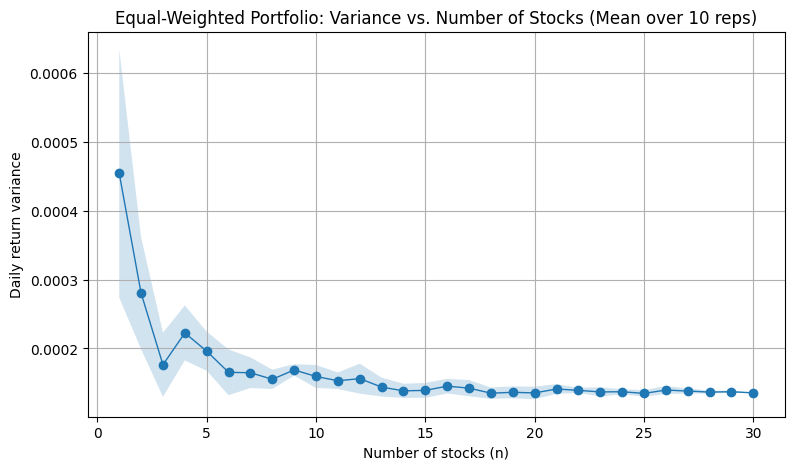

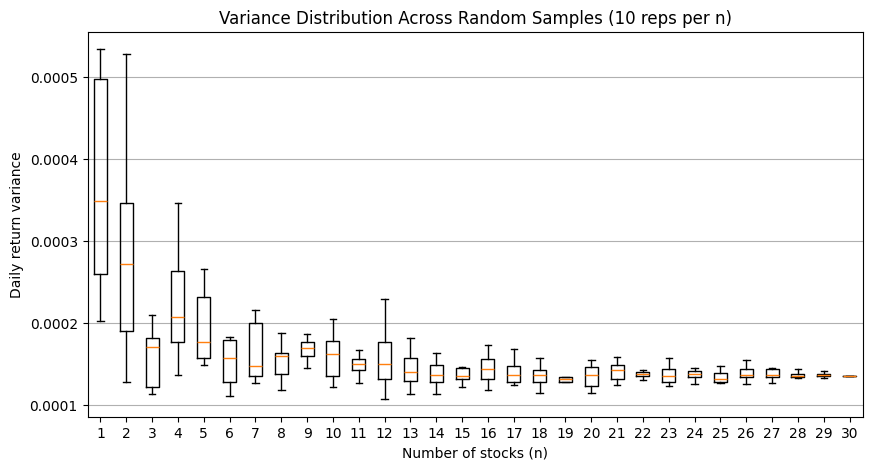

,n,rep,variance
0,1,1,0.000259
1,1,2,0.000375
2,1,3,0.000322
3,1,4,0.000533
4,1,5,0.000388


,n,mean,std,median,min,max,se,ci_low,ci_high
0,1,0.000454,0.000291,0.000349,0.000202,0.001061,0.000092,0.000274,0.000634
1,2,0.000280,0.000131,0.000272,0.000129,0.000528,0.000041,0.000199,0.000361
2,3,0.000176,0.000075,0.000171,0.000113,0.000368,0.000024,0.000130,0.000223
3,4,0.000223,0.000064,0.000207,0.000137,0.000346,0.000020,0.000183,0.000262
4,5,0.000196,0.000046,0.000177,0.000149,0.000266,0.000014,0.000168,0.000224


In [ ]:
tickers = list(tickers30)
rets = (
    tri_30.set_index("Dates")[tickers]
    .astype(float)
    .pct_change()
    .dropna()
)

num_reps = 10
rng = np.random.default_rng(42)

rows = []
for n in range(1, len(tickers) + 1):
    for rep in range(1, num_reps + 1):
        sample = rng.choice(tickers, size=n, replace=False)
        port_rets = rets[list(sample)].mean(axis=1)
        var = float(port_rets.var(ddof=1))
        rows.append({"n": n, "rep": rep, "variance": var})

exp = pd.DataFrame(rows)

agg = (
    exp.groupby("n")["variance"]
    .agg(["mean", "std", "median", "min", "max"])
    .reset_index()
)
agg["se"] = agg["std"] / np.sqrt(num_reps)
agg["ci_low"] = agg["mean"] - 1.96 * agg["se"]
agg["ci_high"] = agg["mean"] + 1.96 * agg["se"]

plt.figure(figsize=(10, 5))
plt.plot(agg["n"], agg["mean"], marker="o", linewidth=1)
plt.fill_between(agg["n"], agg["ci_low"], agg["ci_high"], alpha=0.2)
plt.title("Equal-Weighted Portfolio: Variance vs. Number of Stocks (Mean over 10 reps)")
plt.xlabel("Number of stocks (n)")
plt.ylabel("Daily return variance")
plt.grid(True)

plt.figure(figsize=(10, 5))
data_for_box = [exp.loc[exp["n"] == n, "variance"].values for n in range(1, len(tickers) + 1)]
plt.boxplot(data_for_box, positions=list(range(1, len(tickers) + 1)), showfliers=False)
plt.title("Variance Distribution Across Random Samples (10 reps per n)")
plt.xlabel("Number of stocks (n)")
plt.ylabel("Daily return variance")
plt.grid(True, axis="y")

plt.show()

display(exp.head(), agg.head())

NameError: name 'sp500_returns' is not defined